In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Low-Rank Regression Model
class LowRankRegression(nn.Module):
    def __init__(self, input_dim, output_dim, rank):
        """
        Args:
            input_dim: Number of input features
            output_dim: Number of output features
            rank: Rank for the low-rank decomposition
        """
        super(LowRankRegression, self).__init__()
        # Low-rank factor matrices
        self.U = nn.Parameter(torch.randn(input_dim, rank))
        self.V = nn.Parameter(torch.randn(output_dim, rank))
        
    def forward(self, X):
        """
        Forward pass: X -> Output
        Args:
            X: Input data of shape (batch_size, input_dim)
        Returns:
            Predicted output of shape (batch_size, output_dim)
        """
        W = self.U @ self.V.T  # Low-rank approximation of W
        return X @ W

# Generate Synthetic Data for Testing
def generate_data(n_samples, input_dim, output_dim, noise_std=0.1):
    """
    Generate synthetic data for testing.
    Args:
        n_samples: Number of samples
        input_dim: Number of input features
        output_dim: Number of output features
        noise_std: Standard deviation of noise
    Returns:
        X, Y: Input data and target outputs
    """
    torch.manual_seed(0)  # For reproducibility
    true_W = torch.randn(input_dim, output_dim)
    X = torch.randn(n_samples, input_dim)
    noise = noise_std * torch.randn(n_samples, output_dim)
    Y = X @ true_W + noise
    return X, Y

# Training the Model
def train_model(model, X, Y, lambda_=1.0 ,lr=0.01, n_epochs=100):
    """
    Train the low-rank regression model.
    Args:
        model: Low-rank regression model
        X: Input data
        Y: Target outputs
        lr: Learning rate
        n_epochs: Number of epochs
    Returns:
        Trained model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X)
        loss = loss_fn(predictions, Y) + lambda_* torch.norm(model.U @ model.V.T)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}")
    return model

# Hyperparameters
input_dim = 10
output_dim = 5
rank = 3
n_samples = 100

# Generate data
X, Y = generate_data(n_samples, input_dim, output_dim)

# Initialize and train the model
model = LowRankRegression(input_dim=input_dim, output_dim=output_dim, rank=rank)
trained_model = train_model(model, X, Y, lr=0.01, n_epochs=200)

# Test the model
model.eval()
with torch.no_grad():
    test_predictions = model(X)
    print("Predictions shape:", test_predictions.shape)

Epoch 10/200, Loss: 34.8750
Epoch 20/200, Loss: 27.1500
Epoch 30/200, Loss: 21.7857
Epoch 40/200, Loss: 17.9869
Epoch 50/200, Loss: 15.2536
Epoch 60/200, Loss: 13.2645
Epoch 70/200, Loss: 11.8022
Epoch 80/200, Loss: 10.7191
Epoch 90/200, Loss: 9.9143
Epoch 100/200, Loss: 9.3143
Epoch 110/200, Loss: 8.8641
Epoch 120/200, Loss: 8.5234
Epoch 130/200, Loss: 8.2634
Epoch 140/200, Loss: 8.0641
Epoch 150/200, Loss: 7.9110
Epoch 160/200, Loss: 7.7930
Epoch 170/200, Loss: 7.7013
Epoch 180/200, Loss: 7.6292
Epoch 190/200, Loss: 7.5717
Epoch 200/200, Loss: 7.5250
Predictions shape: torch.Size([100, 5])


In [2]:
Y.shape

torch.Size([100, 5])

In [3]:
X.shape

torch.Size([100, 10])

In [4]:
# Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [5]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


In [6]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

In [7]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

In [8]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

In [9]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    y_tmp = np.zeros((len(dic_reduced_ssp585[m].keys()),time_period, lat_size*lon_size))
    
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp[idx_i,:,:] = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[idx_i,:,nan_idx] = float('nan')
           
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp[idx_i,:,:] - mean_ref_ensemble

/tmp/ipykernel_41466/2788081108.py:17: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_41466/2788081108.py:19: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp[idx_i,:,:],axis=0)/ len(dic_reduced_ssp585[m].keys())


In [10]:
# compute the forced response
dic_forced_response_ssp585 = dict({})
dic_forced_response_ssp585_tmp = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()
    dic_forced_response_ssp585_tmp[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = y_tmp/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += y_tmp/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)
    # dic_forced_response_ssp585_tmp[m] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

In [11]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    y_forced_response[m] = dic_forced_response_ssp585_tmp[m]
    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')

In [12]:
# # compute the variance
# variance_processed_ssp585 = {}
# std_processed_ssp585 = {}
# for idx_m,m in enumerate(x_predictor.keys()):
#     variance_processed_ssp585[m] = {}
#     arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
#     for idx_i, i in enumerate(list(x_predictor[m].keys())):
#         arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

#     arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
#     for idx_i, i in enumerate(x_predictor[m].keys()):
#         arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

#     variance_processed_ssp585[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))

In [13]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
    x_predictor_concatenate[m][:,nan_idx] = float('nan')
    y_forced_response_concatenate[m][:,nan_idx] = float('nan')

In [14]:
# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train[m] = torch.nan_to_num(torch.from_numpy(y_forced_response_concatenate[m])).to(torch.float64)

In [15]:
# We want X in R^{grid x runs*time steps}
x_tmp = torch.zeros(count_x, lat_size*lon_size)
y_tmp = torch.zeros(count_x, lat_size*lon_size)

m0 = 'KACE-1-0-G'
x_test = torch.zeros(len(x_predictor[m0].keys())*33, lat_size*lon_size)
y_test = torch.zeros(len(x_predictor[m0].keys())*33, lat_size*lon_size)

count_tmp =0

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    if m != 'KACE-1-0-G':

        if count_tmp ==0:
            x_tmp[:x_train[m].shape[0],:] = x_train[m]
            y_tmp[:y_train[m].shape[0],:] = y_train[m]
            count_tmp = x_train[m].shape[0]
    
        else:
            x_tmp[count_tmp:count_tmp+x_train[m].shape[0],:] = x_train[m]
            y_tmp[count_tmp:count_tmp+y_train[m].shape[0],:] = y_train[m]
            count_tmp = x_train[m].shape[0]

    else: 
        x_test = x_train[m]
        y_test = y_train[m]

In [22]:
n_predictors

2592

In [16]:
n_samples = count_x
n_predictors = lat_size*lon_size
n_responses = lat_size*lon_size
rank = 5

lambda_ = 1.0

# Initialize and train the model
model = LowRankRegression(input_dim=n_predictors, output_dim=n_predictors, rank=rank)
trained_model = train_model(model, x_tmp, y_tmp, lr=0.01, n_epochs=200)

Epoch 10/200, Loss: 5025.8481
Epoch 20/200, Loss: 4263.9224
Epoch 30/200, Loss: 3615.4265
Epoch 40/200, Loss: 3067.6111
Epoch 50/200, Loss: 2605.6980
Epoch 60/200, Loss: 2215.6899
Epoch 70/200, Loss: 1885.1710
Epoch 80/200, Loss: 1603.2621
Epoch 90/200, Loss: 1360.6085
Epoch 100/200, Loss: 1148.3893
Epoch 110/200, Loss: 958.5219
Epoch 120/200, Loss: 783.3788
Epoch 130/200, Loss: 617.4946
Epoch 140/200, Loss: 459.7259
Epoch 150/200, Loss: 315.4789
Epoch 160/200, Loss: 195.5301
Epoch 170/200, Loss: 108.9090
Epoch 180/200, Loss: 55.1825
Epoch 190/200, Loss: 25.9703
Epoch 200/200, Loss: 13.5168


In [28]:
x_tmp.shape

torch.Size([284064, 2592])

In [23]:
W = model.U @ model.V.T  # Low-rank approximation of W

In [19]:
y_pred = x_test @ W.to(torch.float64)

In [20]:
print("Norm", torch.norm(y_test-y_pred,p='fro'))

Norm tensor(4282.2622, dtype=torch.float64, grad_fn=<LinalgVectorNormBackward0>)


In [21]:
# Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam([model.W,model.C], lr=0.1)
    
# # Training loop
# n_epochs = 1000
# for epoch in range(n_epochs):
#     model.train()
        
#     # Forward pass
#     y_pred = model(x_tmp)
        
#     # Compute loss
#     # loss = criterion(y_pred,y_tmp) + lambda_*torch.norm(torch.matmul(model.W,model.C),p='fro')
#     loss = torch.norm(y_pred-y_tmp, p='fro')**2 + lambda_*torch.norm(model.W,p='fro') + lambda_*torch.norm(model.W, p='fro')**2 
    
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
        
#     if (epoch+1) % 2 == 0:
#         print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')
#         # print(torch.mean((y_pred - y_tmp)**2))
    
# print("Training complete.")

# M  = torch.matmul(model.W.detach(), model.C.detach())
# MX = model.C[1,:].detach()

AttributeError: 'LowRankRegression' object has no attribute 'W'

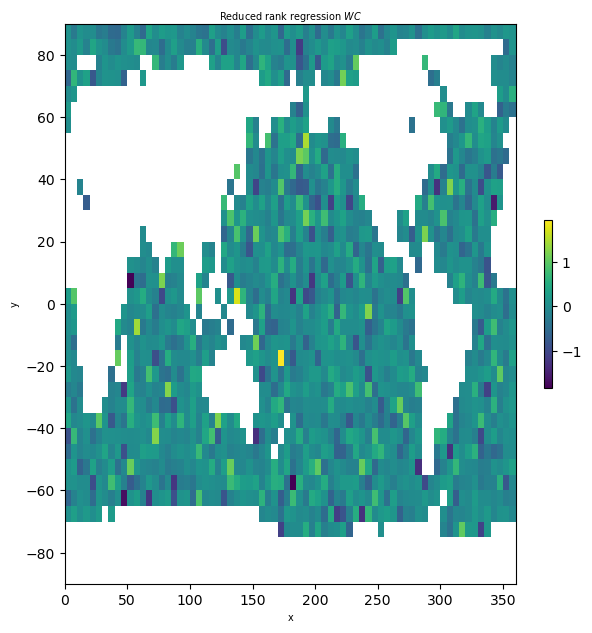

In [27]:
# define beta to plot
M_tmp = model.V[:,0].detach().clone()
M_tmp[nan_idx] = float('nan')
M_tmp = M_tmp.detach().numpy().reshape(lat_size,lon_size)

# define robust beta
# beta_robust_tmp = beta_robust.detach().clone()
# beta_robust_tmp[nan_idx] = float('nan')
# beta_robust_tmp = beta_robust_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title(r'Reduced rank regression $WC$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,M_tmp)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(2, 2, 2)        
# ax1.set_title(r'Robust regression coefficient $\beta_{\mathrm{rob}}$', size=7,pad=3.0)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,beta_robust_tmp,vmin=-0.00,vmax = 0.001)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

plt.show()